# Audio Recognition

In [7]:
#import pyaudio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

import os
import numpy as np
import pandas as pd
import random

# from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

#To find the duration of wave file in seconds
# import wave
# import contextlib
# import librosa
# import soundfile as sf

# Other imports. Can they be deleted?
# import time
# import datetime

import tensorflow as tf
import keras

# custom functions
from speech_dependencies import save_model_to_disk, graph_spectrogram, load_waves
from model_dependencies import new_keras, plot_results
plt.rcParams['figure.dpi'] = 80

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


## Creating a Directory for the Files

In [3]:
folder_names = [f for f in os.listdir('train/audio') if not 'background' in f]
folder_names.sort()

file = open("train/testing_list.txt", "r")
testing_list = file.read().split('\n')
file.close()
file = open("train/validation_list.txt", "r")
validation_list = file.read().split('\n')

master_file_list = []
master_target_list = []
train_val_test_list = []
for phrase in folder_names:
    file_list = [phrase + '/' + f for f in os.listdir('train/audio/' + phrase) if '.wav' in f]
    for file in file_list:
        if file in testing_list:
            train_val_test_list.append('test')
        elif file in validation_list:
            train_val_test_list.append('val')
        else:
            train_val_test_list.append('train')
        master_target_list.append(phrase)
        master_file_list.append(file)
data = np.transpose(np.array([master_file_list, master_target_list, train_val_test_list]))
master_df = pd.DataFrame(data = data, columns=['filename','target','train_val_test'])
master_df.head()

,filename,target,train_val_test
0,bed/00176480_nohash_0.wav,bed,train
1,bed/004ae714_nohash_0.wav,bed,train
2,bed/004ae714_nohash_1.wav,bed,train
3,bed/00f0204f_nohash_0.wav,bed,train
4,bed/00f0204f_nohash_1.wav,bed,train


## Loading the Files and Training the Model

In [4]:
def train_val_load(X, y, num_classes, train_or_val):
    if train_or_val == 'train':
        print('loading training set')
    else:
        print('loading validation set')
        
    sound_clips = []
    for ind, fpath in enumerate(X):
        # update code to `try` loading pickles
        # or preprocess sound clips and save as pickles
        redgram = load_waves(fpath)
        if redgram.shape[0] != 14:
            print('\tbad redgram shape')
            # if experiencing sporadic accuracy between batches
            # see if it's on the 'bad normgram shape' batches
            # might be an indexing error
            y = np.delete(y, ind)
            continue
        sound_clips.append(redgram)
    sound_clips = np.asarray(sound_clips, dtype=np.float32)
#     sound_clips = np.array(sound_clips, dtype=np.float32)
    print(f'\tx shape (before reshape):{sound_clips.shape}')
    sound_clips = sound_clips.reshape( # maybe this is the error? looks like one of the sound clips had a super choppy spectrogram
                                sound_clips.shape[0],
                                sound_clips.shape[1], 
                                sound_clips.shape[2],1)
    print(f'\tx shape (after reshape):{sound_clips.shape}')
    
    for y_ind in range(len(y)):
        y[y_ind] = mapping[y[y_ind]]
    y = keras.utils.to_categorical(y, num_classes) # this might be the part that's fubar, try keras ohe. should still work decent for the number of samples tho?
    print(f'\ty shape:{y.shape}')
    
    # to see if the spectrogram looks decent
    sns.heatmap(sound_clips[0][:,:,0])
    plt.show()
    
    return sound_clips, y

In [5]:
num_classes = len(master_df['target'].unique().tolist())
# SKF is just being used to batch the data into memory, not do any sort of k-fold training process

X_master = master_df['filename'][[(val in ['train','val']) for val in master_df['train_val_test']]]
y_master = master_df['target'][[(val in ['train','val']) for val in master_df['train_val_test']]]
X_master, y_master = np.array(X_master), np.array(y_master)

y_master_set = list(set(y_master))
mapping = {}
for y in range(len(y_master_set)):
    mapping[y_master_set[y]] = y
print(f'Label mapping:\n{mapping}')

Label mapping:
{'seven': 0, 'five': 1, 'one': 2, 'go': 3, 'right': 4, 'yes': 5, 'four': 6, 'bird': 7, 'zero': 8, 'tree': 9, 'six': 10, 'sheila': 11, 'two': 12, 'up': 13, 'wow': 14, 'down': 15, 'no': 16, 'three': 17, 'marvin': 18, 'house': 19, 'cat': 20, 'happy': 21, 'eight': 22, 'left': 23, 'nine': 24, 'off': 25, 'on': 26, 'stop': 27, 'bed': 28, 'dog': 29}


# from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
# from tensorflow.python.platform import tf_logging as logging

# class ReduceLRBacktrack(ReduceLROnPlateau):
#     def __init__(self, best_path, *args, **kwargs):
#         super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
#         self.best_path = best_path

#     def on_epoch_end(self, epoch, logs=None):
#         current = logs.get(self.monitor)
#         if current is None:
#             logging.warning('Reduce LR on plateau conditioned on metric `%s` '
#                             'which is not available. Available metrics are: %s',
#                              self.monitor, ','.join(list(logs.keys())))
#         if not self.monitor_op(current, self.best): # not new best
#             if not self.in_cooldown(): # and we're not in cooldown
#                 if self.wait+1 >= self.patience: # going to reduce lr
#                     # load best model so far
#                     print("Backtracking to best model before reducting LR")
#                     self.model.load_weights(self.best_path)

#         super().on_epoch_end(epoch, logs) # actually reduce LR

# model_checkpoint_path = 'MyModel_tf/checkpoint.h5'

# c1 = ModelCheckpoint(model_checkpoint_path, 
#                      save_best_only=True,
# #                      monitor='val_loss')
#                      monitor='val_accuracy')
# c2 = ReduceLRBacktrack(best_path=model_checkpoint_path,
# #                        monitor='val_loss',
#                        monitor='val_accuracy',
#                        factor=0.1,
#                        patience=5)
# c3 = EarlyStopping(monitor='val_accuracy',
#                 patience=20,
#                 verbose=1,
#                 restore_best_weights=True)

#############################################################################################################################################
## Can probably use the custom callback(s), looks like the accuracy was messed up by Adam(learning_rate = 0.01) not the callback functions ##
#############################################################################################################################################
### Maybe not??? works fine without the callbacks. Maybe monitoring val_loss might be better... who knowssssss O_O ###
######################################################################################################################
c1 = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.1,
                    patience=5,
                    verbose=1)
c2 = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                verbose=1,
                restore_best_weights=True)

working on batch: 125/150h 124, already trained up to batch 125. skipping...
loading training set


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(289, 14, 20)
	x shape (after reshape):(289, 14, 20, 1)
	y shape:(289, 30)


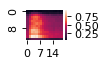

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


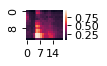

Loading an existing model
Epoch 1/5
10/10 [==============================] - 9s 43ms/step - loss: 3.3986 - accuracy: 0.0519 - val_loss: 3.4228 - val_accuracy: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 0s 10ms/step - loss: 3.3875 - accuracy: 0.0484 - val_loss: 3.4295 - val_accuracy: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 0s 13ms/step - loss: 3.3854 - accuracy: 0.0484 - val_loss: 3.4350 - val_accuracy: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 0s 11ms/step - loss: 3.3875 - accuracy: 0.0484 - val_loss: 3.4295 - val_accuracy: 0.0000e+00
Epoch 5/5
10/10 [==============================] - 0s 12ms/step - loss: 3.3759 - accuracy: 0.0519 - val_loss: 3.4386 - val_accuracy: 0.0000e+00


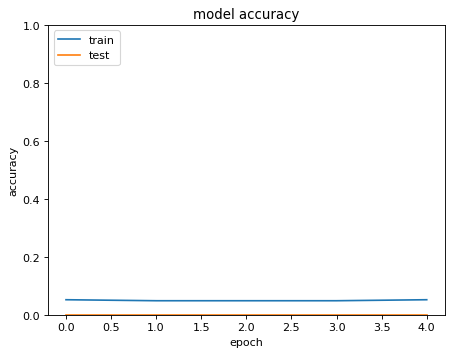

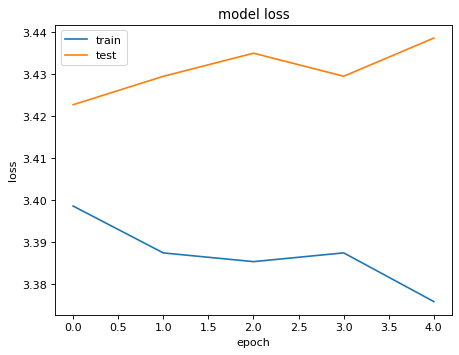

INFO:tensorflow:Assets written to: ./MyModel_tf\assets
working on batch: 126/150
loading training set
	bad redgram shape


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(288, 14, 20)
	x shape (after reshape):(288, 14, 20, 1)
	y shape:(288, 30)


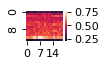

loading validation set


KeyboardInterrupt: 

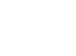

In [8]:
batch_count = 1 # using a counter since enumerate doesn't work on skf.split
total_splits = 150
skf = StratifiedKFold(n_splits=total_splits, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_master, y_master):
    if batch_count < 125:
        print(f'currently looking at batch {batch_count}, already trained up to batch 125. skipping...', end='\r')
        batch_count += 1
        continue
    print(f'working on batch: {batch_count}/{total_splits}')
    rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=42)
    X, y = X_master[test_index], y_master[test_index]
    for train_index2, test_index2 in rs.split(X):
        X_train, X_val = X[train_index2], X[test_index2]
        y_train, y_val = y[train_index2], y[test_index2]
        # Split is done, X=filename, y=target
        X_train, y_train = train_val_load(X_train, y_train, num_classes, train_or_val = 'train')
        X_val, y_val = train_val_load(X_val, y_val, num_classes, train_or_val = 'val')
        
        try:
            loaded_model = tf.keras.models.load_model('./MyModel_tf')
            print("Loading an existing model")
#             history = loaded_model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=[c1,c2,c3], verbose=1, validation_data=(X_val, y_val))
            history = loaded_model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(X_val, y_val))
            plot_results(history)
            loaded_model.save('./MyModel_tf',save_format='tf')
        except:
            print("Starting with a fresh model")
            model = new_keras(input_shape=(
                                    X_train.shape[1], 
                                    X_train.shape[2],1))
#             history = model.fit(X_train, y_train, batch_size=16, epochs=30, callbacks=[c1,c2,c3], verbose=1, validation_data=(X_val, y_val))
            history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(X_val, y_val))
            # Just deleted the callbacks from the previous line, try running again in the morning,
            # Also maybe make another branch called development and quit pushing all this garbage.....
            plot_results(history)
            model.save('./MyModel_tf',save_format='tf')
            model=[]
        X_train, y_train, X_val, y_val = [],[],[],[]
    batch_count += 1

In [ ]:
save_model_to_disk(model)

working on batch: 1/150
loading training set


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(289, 14, 20)
	x shape (after reshape):(289, 14, 20, 1)
	y shape:(289, 30)


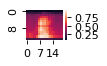

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


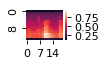

Starting with a fresh model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 10, 16, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)           

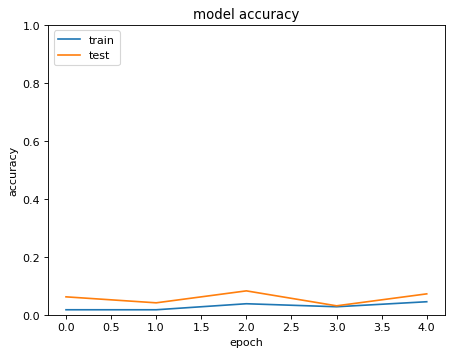

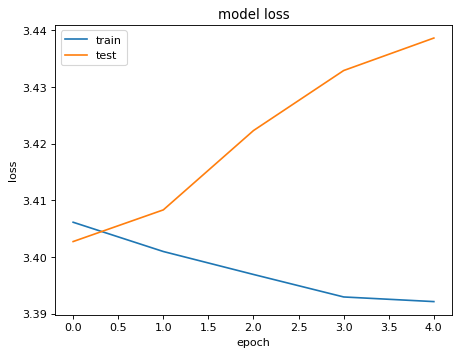

Saved model to disk
Saved model to disk
working on batch: 2/150
loading training set
	bad redgram shape
	x shape (before reshape):(288, 14, 20)
	x shape (after reshape):(288, 14, 20, 1)
	y shape:(288, 30)


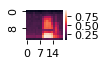

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


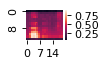

Starting with a fresh model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 10, 16, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)           

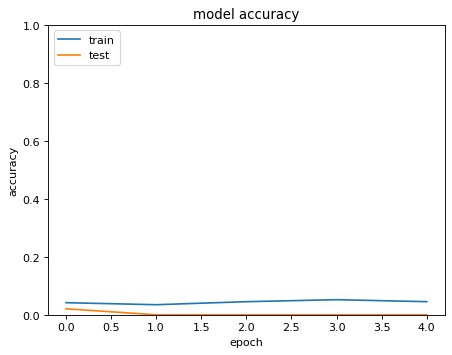

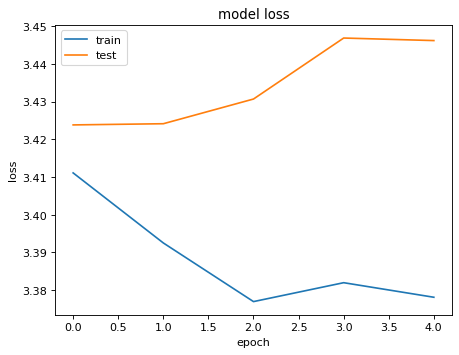

Saved model to disk
Saved model to disk
working on batch: 3/150
working on batch: 4/150
working on batch: 5/150
working on batch: 6/150
working on batch: 7/150
working on batch: 8/150
working on batch: 9/150
working on batch: 10/150
working on batch: 11/150
working on batch: 12/150
working on batch: 13/150
working on batch: 14/150
working on batch: 15/150
working on batch: 16/150
working on batch: 17/150
working on batch: 18/150
working on batch: 19/150
working on batch: 20/150
working on batch: 21/150
working on batch: 22/150
working on batch: 23/150
working on batch: 24/150
working on batch: 25/150
working on batch: 26/150
working on batch: 27/150
working on batch: 28/150
working on batch: 29/150
working on batch: 30/150
working on batch: 31/150
working on batch: 32/150
working on batch: 33/150
working on batch: 34/150
working on batch: 35/150
working on batch: 36/150
working on batch: 37/150
working on batch: 38/150
working on batch: 39/150
working on batch: 40/150
working on batch:

In [10]:
batch_count = 1 # using a counter since enumerate doesn't work on skf.split
total_splits = 150
skf = StratifiedKFold(n_splits=total_splits, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_master, y_master):
    print(f'working on batch: {batch_count}/{total_splits}')
    rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=42)
    X, y = X_master[test_index], y_master[test_index]
    for train_index2, test_index2 in rs.split(X):
        if batch_count > 2:
            break
        X_train, X_val = X[train_index2], X[test_index2]
        y_train, y_val = y[train_index2], y[test_index2]
        # Split is done, X=filename, y=target
        X_train, y_train = train_val_load(X_train, y_train, num_classes, train_or_val = 'train')
        X_val, y_val = train_val_load(X_val, y_val, num_classes, train_or_val = 'val')
        
        try:
            loaded_model = tf.keras.models.load_model('model.h5')
            print("Loading an existing model")
#             history = loaded_model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=[c1,c2,c3], verbose=1, validation_data=(X_val, y_val))
            history = loaded_model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(X_val, y_val))
            plot_results(history)
#             loaded_model.save('./MyModel_tf',save_format='tf')
            save_model_to_disk(loaded_model)
        except:
            print("Starting with a fresh model")
            model = new_keras(input_shape=(
                                    X_train.shape[1], 
                                    X_train.shape[2],1))
#             history = model.fit(X_train, y_train, batch_size=16, epochs=30, callbacks=[c1,c2,c3], verbose=1, validation_data=(X_val, y_val))
            history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(X_val, y_val))
            # Just deleted the callbacks from the previous line, try running again in the morning,
            # Also maybe make another branch called development and quit pushing all this garbage.....
            plot_results(history)
            save_model_to_disk(model)
#             model.save('./MyModel_tf',save_format='tf')
            save_model_to_disk(model)
            model=[]
        X_train, y_train, X_val, y_val = [],[],[],[]
    batch_count += 1